## Semi Supervised Deep Learning Workshop Exercise - Instructor Version

This notebook contains example code to complete the basic exercises in the hands-on component of the Semi-Supervised Deep Learning workshop.
For complete context, refer to the student version of this notebook. 


In [1]:
# Load the modules we will be using today
import tensorflow as tf
import tensorflow.keras.layers as L
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import random
import pickle

# Preprocess the dataset for convenience
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Normalise the images and remove redundant dimensions
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

# Populate the "dataset" dictionary with the CIFAR-10 data
dataset = {}
dataset['train_images'] = train_images
dataset['train_labels'] = train_labels
dataset['train_images_grouped'] = [ [] for i in range(10) ]
dataset['test_images'] = test_images
dataset['test_labels'] = test_labels

for i in range(train_labels.shape[0]):
  dataset['train_images_grouped'][train_labels[i]].append(train_images[i])


170500096/170498071 [==============================] - 4s 0us/step


Dataset keys: ['train_images', 'train_labels', 'train_images_grouped', 'test_images', 'test_labels']
Training images per class: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
Image shape: (32, 32, 3)


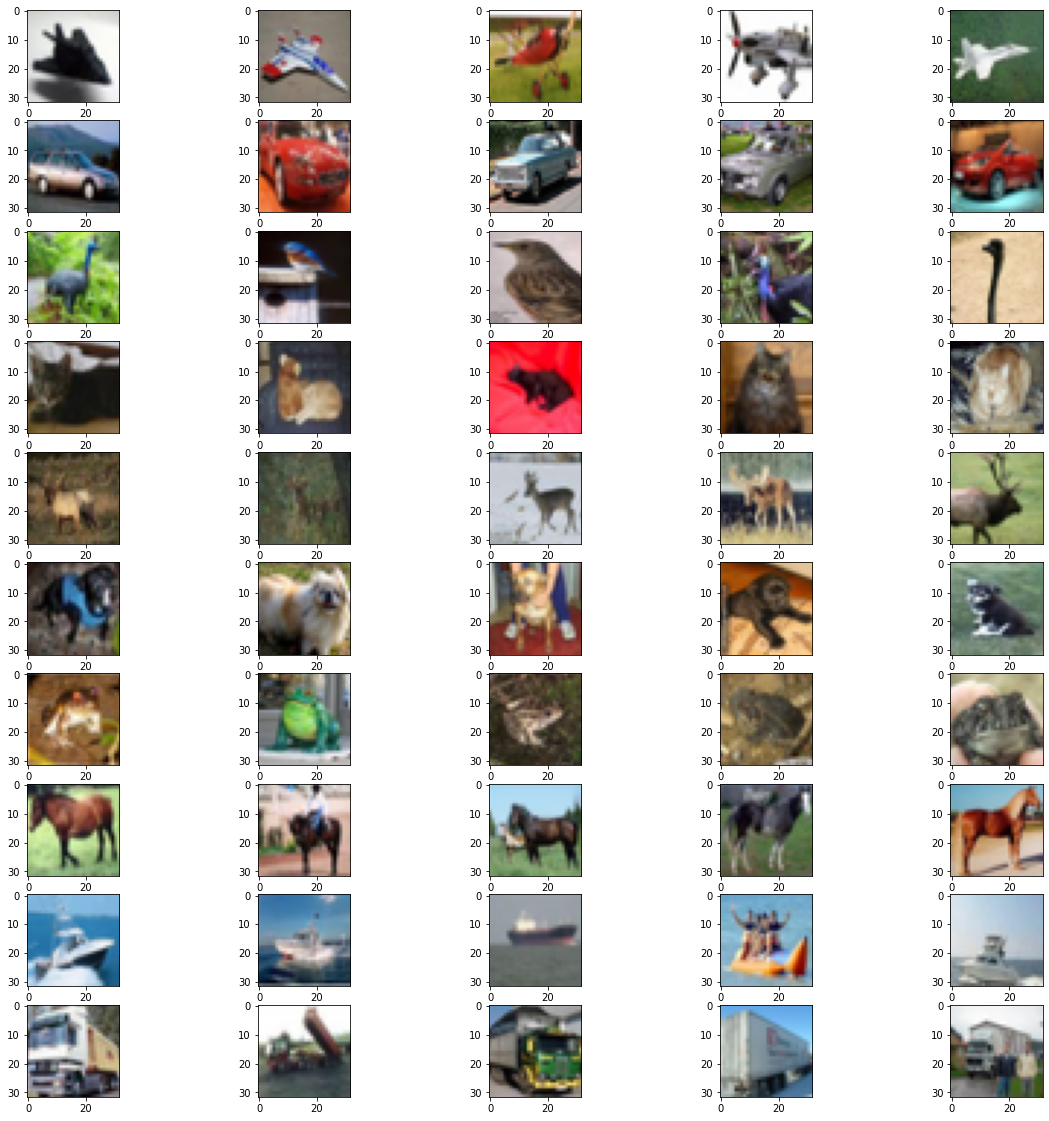

In [2]:
# Inspect the dataset
print('Dataset keys:', [k for k in dataset.keys()])
print('Training images per class:', [len(c) for c in dataset['train_images_grouped']])
print('Image shape:', dataset['train_images_grouped'][0][0].shape)

fig=plt.figure(figsize=(20, 20))
rows = 10 # Show all 10 classes
columns = 5 # Show 5 samples per class
for i in range(rows):
  for j in range(columns):
    fig.add_subplot(rows, columns, (i)*columns+j+1)
    plt.imshow(dataset['train_images_grouped'][i][j])
plt.show()



In [5]:
# Extract the first 1% of labelled samples
take_first_X = 50
train_images_supervised = []; train_labels_supervised = []
for i in range(10):
    train_images_supervised += dataset['train_images_grouped'][i][:take_first_X]
    train_labels_supervised += [i] * take_first_X

train_images_supervised = np.asarray(train_images_supervised)
train_labels_supervised = np.asarray(train_labels_supervised, np.int32)


In [6]:
# Define the model architecture
class SimpleModel(tf.keras.Model):
  def __init__(self):
    super(SimpleModel, self).__init__()

    # Encoder layers
    # Hint: You may choose to use keras.layers.Conv2D
    self.enConv1 = L.Conv2D(16,(3,3), padding='same', activation='relu')
    self.enConv2 = L.Conv2D(32,(3,3), padding='same', activation='relu')
    self.enConv3 = L.Conv2D(64,(3,3), padding='same', activation='relu')

    # Classification head layers
    # Hint: You may choose to use keras.layers.Dense
    self.dense1 = L.Dense(32, activation='relu')
    self.dense2 = L.Dense(10, activation=None)

    # Decoder head layers
    # Hint: You may choose to use keras.layers.Conv2DTranspose
    # Creating an output the same shape as the input using deconvolution layers may be tricky
    # Using padding='same' makes it easier.
    self.deConv1 = L.Conv2DTranspose(32, (3,3), padding='same', strides=(2,2), activation='relu')
    self.deConv2 = L.Conv2DTranspose(3, (3,3), padding='same', strides=(2,2), activation='sigmoid')

  def call(self, x):
    # Encoder
    x = self.enConv1(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = self.enConv2(x)
    x = L.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = self.enConv3(x)

    # Classification head
    c = L.Flatten()(x)
    c = self.dense1(c)
    c = self.dense2(c)

    # Decoder head
    s = self.deConv1(x)
    s = self.deConv2(s)

    return c, s

# Define the loss function
def SemiSupervised_CrossEntropy_or_MSE(labels, inputs, logits, regen_img, mode='supervised'):

    if mode == 'supervised':
      # Classification loss is necessary since this is the supervised loss
      classification_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))

      # Regeneration loss is not strictly necessary
      reconstruction_loss = tf.reduce_mean(tf.square(inputs-regen_img))

      return classification_loss + reconstruction_loss

    else:
      # Classification loss is 0 as it is not used here
      classification_loss = tf.reduce_mean(0.*logits)

      # Regeneration loss is simply the L2 loss
      reconstruction_loss = tf.reduce_mean(tf.square(inputs-regen_img))

      return classification_loss + reconstruction_loss

# Define a validation function
def ValidateModel(model, test_images, test_labels):
  predictions, seg = model.predict(test_images)
  predicted_classes = np.argmax(predictions, axis=-1)
  accuracy = 1. * np.sum(predicted_classes == test_labels) / test_labels.shape[0]
  print('Validation accuracy =', accuracy)
  confusion_matrix = np.zeros((10,10))
  for i in range(test_labels.shape[0]):
    confusion_matrix[test_labels[i],predicted_classes[i]] += 1
  print(confusion_matrix)

In [8]:
# The main training script
# The easiest way to toggle between semi-supervised and supervised training is to change the initial value of supervised_prob = 50 to 100
# With 1% of labelled data, this example script is able to achieve ~1% improvement in validation results using semi-supervised training.

model = SimpleModel()
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)

accumulated_loss = 0
supervised_prob = 100  # Probability of sampling a supervised batch for training
max_train_batches = 3000
batch_size = 32

train_batch = 1
while train_batch < max_train_batches:

    # Example of increasing the supervised probability throughout training
    if train_batch % 250 == 0:
      supervised_prob += 10

    supervised_or_unsupervised = np.random.randint(0,100)
    train_batch += 1
    if supervised_or_unsupervised < supervised_prob: # if supervised
      
      input_batch = []; label_batch = []
      for i in range(batch_size):
        x = np.random.randint(0, train_images_supervised.shape[0])
        input_batch.append(train_images_supervised[x])
        label_batch.append(train_labels_supervised[x])
        
    else: # if unsupervised
        input_batch = []
        for i in range(batch_size):
          x = np.random.randint(0, dataset['train_images'].shape[0])
          input_batch.append(dataset['train_images'][x])

    with tf.GradientTape() as tape:
      input_batch = np.asarray(input_batch)
      logits, regen_img = model(input_batch, training=True)
      
      # Calculate the loss depending on training mode
      if supervised_or_unsupervised < supervised_prob: # Supervised mode
          loss = SemiSupervised_CrossEntropy_or_MSE(np.asarray(label_batch), input_batch, logits, regen_img,
                                                                  mode='supervised')
      else: # Unsupervised mode
          loss = SemiSupervised_CrossEntropy_or_MSE(None, input_batch, logits, regen_img,
                                                                  mode='unsupervised')
      
      # Perform gradient descent on the loss    
      gradients = tape.gradient(loss, model.trainable_variables)
      optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    accumulated_loss += loss.numpy()

    # Validation at every certain number of batches
    if train_batch % 250 == 0:
      print('Validation at train batch', train_batch)
      ValidateModel(model, dataset['test_images'], dataset['test_labels'])



Validation at train batch 250
Validation accuracy = 0.1813
[[  0. 218. 107.   0.   0.   0.   1.   3. 345. 326.]
 [  0. 427.  27.   0.   0.   1.   8.   8.  23. 506.]
 [  0. 303. 214.   3.   0.  12.  27.  20.  95. 326.]
 [  0. 365. 178.   4.   0.  23.  66.  14.  12. 338.]
 [  0. 355. 166.   3.   0.   6.  95.  38.  34. 303.]
 [  0. 448. 133.   7.   0.  17.  57.  23.  14. 301.]
 [  0. 436. 112.   3.   0.   8.  86.  17.   5. 333.]
 [  0. 265. 143.   2.   0.  10.  37.  27.  12. 504.]
 [  0. 285.  30.   0.   0.   0.   2.   2. 288. 393.]
 [  0. 173.  29.   2.   0.   1.   2.   9.  34. 750.]]
Validation at train batch 500
Validation accuracy = 0.3022
[[408.  88.  37.   5.  36.  16.  11.  21. 310.  68.]
 [123. 419.  10.   5.  52.  64.  28.  34.  61. 204.]
 [129.  81. 139.  24. 217. 114. 106.  42.  95.  53.]
 [ 75. 103. 126.  66. 119. 204. 132.  48.  25. 102.]
 [ 63.  65. 117.  13. 291. 110. 185.  55.  48.  53.]
 [ 64.  89. 120.  41. 199. 241. 107.  53.  34.  52.]
 [ 41. 103.  78.  29. 214. 112. 3

### Miscellaneous example code

In [ ]:
# A function to randomly shuffle two associated lists (such as images and labels) in the same order
def randshuf(a,b):
  c = list(zip(a,b))
  random.shuffle(c)
  a,b = zip(*c)
  return a,b

# A function to add Gaussian noise to the input images
def AddNoise(images, range):
  for i, img in enumerate(images):
    img += np.random.normal(loc=0.0, scale=range, size=img.shape)
  return images

# Or add noise inline as follows:
# Be sure to not modify the original dataset as it will corrupt the data for future use
input_batch_noise = input_batch + np.random.normal(scale=0.0, size=input_batch.shape)
test_images_noise = test_images + np.random.normal(scale=0.0, size=test_images.shape)